In [1]:
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
sns.set_theme(style="dark")

In [2]:

BATCH_SIZE = 128
EPOCHS = 10
IMG_SIZE = (96, 96)
move_labels = False
convert_to_jpg = False

In [3]:
train_labels = pd.read_csv("data/train_labels.csv")
print(f'Number of training examples: {train_labels.shape[0]}')

Number of training examples: 220025


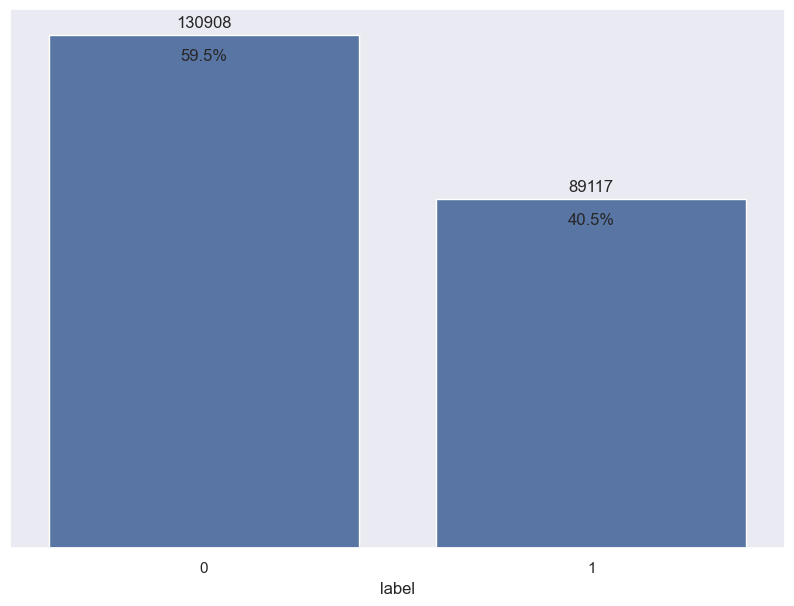

In [4]:
plt.figure(figsize=(10, 7))
bar = sns.countplot(data=train_labels, x="label")
for p in bar.patches:
    bar.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    # annote percentage
    bar.annotate(format(p.get_height() / train_labels.shape[0], '.1%'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, -15), textcoords='offset points')
bar.set(xlabel="label")
plt.ylabel("")
plt.yticks([]);

We have an imbalanced dataset so we need to be careful when splitting the data.

In [5]:
x_train, x_val, y_train, y_val = train_test_split(train_labels["id"], train_labels["label"], test_size=0.2, random_state=42, stratify=train_labels["label"])
print(f'Number of training examples: {x_train.shape[0]}')
print(f'Number of validation examples: {x_val.shape[0]}')

Number of training examples: 176020
Number of validation examples: 44005


In [6]:
os.makedirs("data/train", exist_ok=True)
os.makedirs("data/val", exist_ok=True)
os.makedirs("data/train/0", exist_ok=True)
os.makedirs("data/train/1", exist_ok=True)
os.makedirs("data/val/0", exist_ok=True)
os.makedirs("data/val/1", exist_ok=True)

if move_labels:
    for id, label in zip(x_train, y_train):
        shutil.move(f"data/train/{id}.tif", f"data/train/{label}/{id}.tif")

    for id, label in zip(x_val, y_val):
        shutil.move(f"data/train/{id}.tif", f"data/val/{label}/{id}.tif")
        
if convert_to_jpg:
    for id, label in zip(x_train, y_train):
        img = Image.open(f"data/train/{label}/{id}.tif")
        img.save(f"data/train/{label}/{id}.jpg")
        os.remove(f"data/train/{label}/{id}.tif")

    for id, label in zip(x_val, y_val):
        img = Image.open(f"data/val/{label}/{id}.tif")
        img.save(f"data/val/{label}/{id}.jpg")
        os.remove(f"data/val/{label}/{id}.tif")
        
    files = os.listdir("data/test")
    for f in tqdm(files):
        img = Image.open(f"data/test/{f}")
        img.save(f"data/test/{f[:-4]}.jpg")
        os.remove(f"data/test/{f}")

In [7]:
training_set = keras.utils.image_dataset_from_directory(
    "data/train/",
    labels='inferred',
    color_mode="rgb",
    batch_size=32,
    image_size=(96, 96),
    shuffle=True,
    seed=42
)


Found 176020 files belonging to 2 classes.


In [8]:
validation_set = keras.utils.image_dataset_from_directory(
    "data/val/",
    labels='inferred',
    color_mode="rgb",
    batch_size=32,
    image_size=(96, 96),
    shuffle=True,
    seed=42
)

Found 44005 files belonging to 2 classes.


In [9]:
test_set = keras.utils.image_dataset_from_directory(
    "data/test/",
    labels=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(96, 96),
    shuffle=False,
)

Found 57458 files.


In [10]:
AUTOTUNE = tf.data.AUTOTUNE
training_set = training_set.prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.prefetch(buffer_size=AUTOTUNE)
test_set = test_set.prefetch(buffer_size=AUTOTUNE)

Dimensions of image: (96, 96, 3)
Number of channels: 3
Ranges of each channel: (np.uint8(0), np.uint8(255))


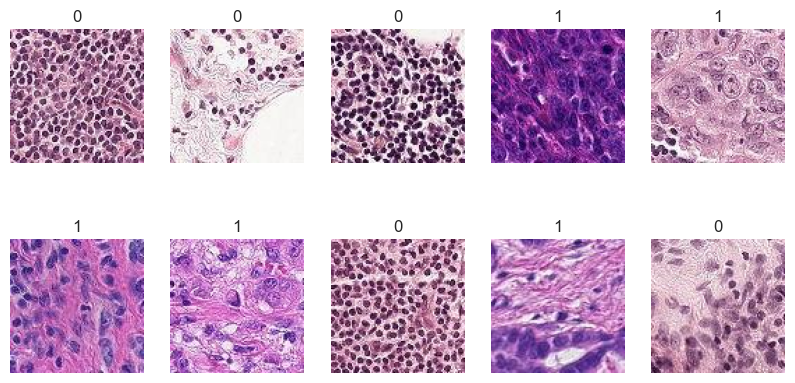

In [11]:
train_labels_sample = y_train.sample(10, random_state=42)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for ax, x, y in zip(axes.ravel(), x_train[train_labels_sample.index], train_labels_sample):
    image = plt.imread(f"data/train/{y}/{x}.jpg")
    ax.imshow(image)
    ax.set_title(y)
    ax.set_axis_off()

print(f'Dimensions of image: {image.shape}')
print(f'Number of channels: {image.shape[2]}')
print(f'Ranges of each channel: {np.min(image), np.max(image)}')

# Hyperparameter Tuning

In [38]:
import keras_tuner as kt

def build_model(hp):
    inputs = keras.Input(shape=(96, 96, 3))
    x = keras.layers.Rescaling(1./255)(inputs)

    # Hiperparámetros: número de bloques Conv2D
    for i in range(3):
        x = keras.layers.Conv2D(
            filters=(i+1)*32,
            kernel_size=3,
            padding="same",
            activation="relu"
        )(x)
        x = keras.layers.MaxPooling2D()(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(hp.Float("dropout", 0.2, 0.5, step=0.1))(x)
    x = keras.layers.Dense(
        hp.Int("dense_units", 32, 128, step=32),
        activation="relu"
    )(x)
    x = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, x)

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
        ),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="roc_auc")]
    )

    return model


In [ ]:
training_set_mini = training_set.take(1000)

In [ ]:
validation_set_mini = validation_set.take(200)

In [42]:
tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective("val_roc_auc", direction="max"),
    max_trials=10,
    seed=42,
    directory="kt_dir",
    project_name="image_classifier_bayesian"

)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",  # or "best_model.h5"
    monitor="val_roc_auc",
    save_best_only=True,
    save_weights_only=False,  # Set True if you want only weights
    mode="max",  # Because we want to maximize roc_auc
    verbose=1
)

tuner.search(
    training_set_mini,
    validation_data = validation_set_mini,
    epochs=5,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_roc_auc", patience=3, mode="max"),
        checkpoint_cb
    ]
)


Trial 1 Complete [00h 48m 07s]
val_roc_auc: 0.9713895916938782

Best val_roc_auc So Far: 0.9713895916938782
Total elapsed time: 00h 48m 07s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
0.2               |0.3               |dropout
128               |32                |dense_units
0.00050547        |0.00065625        |learning_rate

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.4601 - roc_auc: 0.8537
Epoch 1: val_roc_auc improved from -inf to 0.93990, saving model to best_model.keras
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 649s 118ms/step - loss: 0.4601 - roc_auc: 0.8537 - val_loss: 0.3076 - val_roc_auc: 0.9399
Epoch 2/5
1919/5501 ━━━━━━━━━━━━━━━━━━━━ 6:38 111ms/step - loss: 0.3228 - roc_auc: 0.9329

KeyboardInterrupt: 

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]


print("Mejores hiperparámetros:")
for param in best_hps.values:
    print(f"{param}: {best_hps.values[param]}")

Mejores hiperparámetros:
dropout: 0.30000000000000004
dense_units: 32
learning_rate: 0.0006562536901904111


d:\Code\CNN - Cancer detection\venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [45]:
full_train = training_set.concatenate(validation_set)
callbacks = [
    keras.callbacks.ModelCheckpoint("tmp_model/save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]

best_model.fit(full_train, epochs=5, callbacks=callbacks)

Epoch 1/5
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 655s 95ms/step - loss: 0.1942 - roc_auc: 0.9753
Epoch 2/5
   1/6877 ━━━━━━━━━━━━━━━━━━━━ 19:02 166ms/step - loss: 0.5185 - roc_auc: 0.9266

d:\Code\CNN - Cancer detection\venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,roc_auc
  current = self.get_monitor_value(logs)


6877/6877 ━━━━━━━━━━━━━━━━━━━━ 945s 137ms/step - loss: 0.1817 - roc_auc: 0.9783
Epoch 3/5
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 843s 123ms/step - loss: 0.1658 - roc_auc: 0.9818
Epoch 4/5
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 752s 109ms/step - loss: 0.1556 - roc_auc: 0.9839
Epoch 5/5
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 789s 115ms/step - loss: 0.1443 - roc_auc: 0.9860


In [46]:
y_pred = best_model.predict(test_set)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 102s 56ms/step


In [65]:
y_pred_filenames = [f[:-4] for f in os.listdir("data/test/")]

In [67]:
submission = pd.DataFrame()
submission["id"] = y_pred_filenames
submission["label"] = np.where(y_pred > 0.5, 1, 0) 

In [68]:
submission

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,1
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0
...,...,...
57453,fffdd1cbb1ac0800f65309f344dd15e9331e1c53,0
57454,fffdf4b82ba01f9cae88b9fa45be103344d9f6e3,0
57455,fffec7da56b54258038b0d382b3d55010eceb9d7,0
57456,ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6,0


In [69]:
submission['label'].value_counts()  

label
0    36281
1    21177
Name: count, dtype: int64

In [70]:
submission.to_csv("submission.csv", index=False)

In [71]:
!kaggle competitions submit -c histopathologic-cancer-detection -f submission.csv -m "CNN - Fifth iteration"

Successfully submitted to Histopathologic Cancer Detection



  0%|          | 0.00/2.41M [00:00<?, ?B/s]
  1%|          | 16.0k/2.41M [00:00<00:16, 150kB/s]
 20%|██        | 496k/2.41M [00:00<00:00, 2.84MB/s]
 32%|███▏      | 784k/2.41M [00:00<00:00, 2.58MB/s]
 67%|██████▋   | 1.62M/2.41M [00:00<00:00, 4.83MB/s]
100%|██████████| 2.41M/2.41M [00:00<00:00, 5.97MB/s]
100%|██████████| 2.41M/2.41M [00:00<00:00, 2.54MB/s]
